<center><h1> Time Series Analysis on EWMA, SES, Holt's Linear Trend & Holt-Winters Models

-------------

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Loading data into the df
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# Check for missing values
df.isna().sum()

Passengers    0
dtype: int64

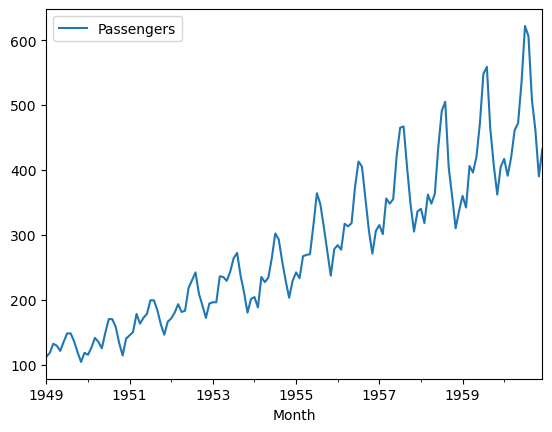

In [5]:
# Plotting the df
df.plot();

## EWMA Model

In [6]:
# Setting the "Smoothing Factor" a.k.a "Decaying Factor" (i.e.,alpha paramaeter) to 0.2. 
alpha = 0.2

In [7]:
# Calculating EWMA for Passengers column
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [8]:
# Checking the type of EWM function
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

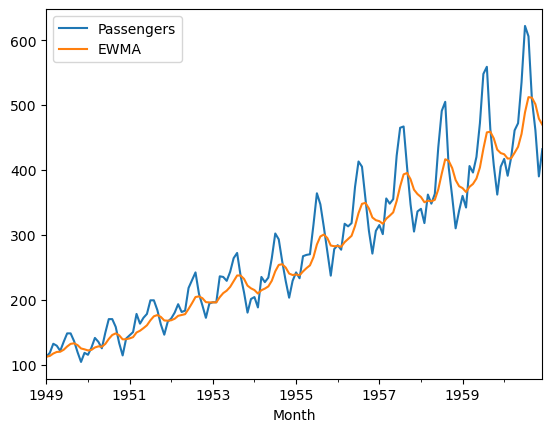

In [9]:
df.plot();

--------------------

## SES Model

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [11]:
# Applying "SES" for Passengers column  
ses = SimpleExpSmoothing(df['Passengers'])

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
# Calling the index for df
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Notice ther freq=None. As a result we get the above warning.

In [13]:
# Fixing the freq
df.index.freq = 'MS'    # MS - Months 

In [14]:
# Including initialization_method parameter to fix the warning 
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')  # initializes the moving average just like in the old versions

We no longer get the above warnings when well call ses now.

In [15]:
# Calling "fit" function on our model
res = ses.fit(smoothing_level=alpha, optimized=False) 

# when "optimized=False" we manually need to provide the alpha value. 
# If set to "True", which is default the statsmodels will automatically find the optimized value for alpha.

In [16]:
# Printing res to see what we are working with (i.e., which class?)
res

In [17]:
# Calling the predict() function on our results (res) object
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

Since we want the predictions for our entire dataset, we are going to pass in the start date equals to the 1st row index of our df and end date equals to the last row index of our df. 

In [18]:
# Calling predict() function again, but assigning it ot a new column called "SES"
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [19]:
# Checking the df to confirm the new column
df

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,113.200000,112.000000
1949-03-01,132,116.960000,113.200000
1949-04-01,129,119.368000,116.960000
1949-05-01,121,119.694400,119.368000
...,...,...,...
1960-08-01,606,512.214093,488.767616
1960-09-01,508,511.371274,512.214093
1960-10-01,461,501.297019,511.371274


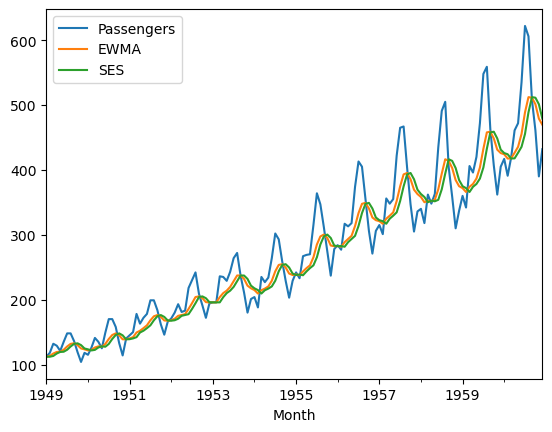

In [20]:
# Plotting the SES model along with the EWMA model
df.plot();

#### Treating this problem like a ML problem

In [21]:
# Splitting the df into "train" and "test" sets
N_test = 12
train  = df.iloc[:-N_test]
test   = df.iloc[-N_test:]

In [22]:
# Recreating the "SES" object, but this time with only the "train" set
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')

# Calling the fit() function without passing "alpha" or "optimized" parameters
res = ses.fit() 

In [23]:
# Creating indices which we use to index our df
train_idx = df.index <= train.index[-1]
test_idx  = df.index > train.index[-1]

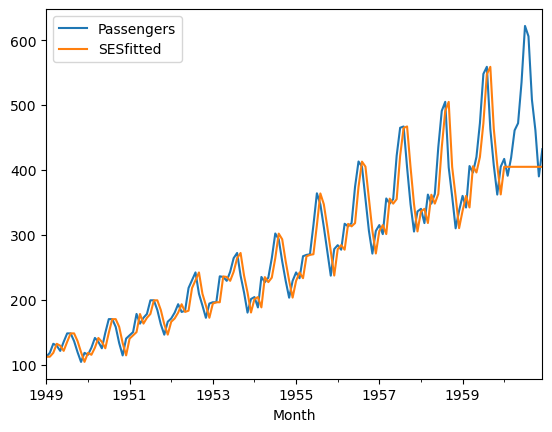

In [24]:
# Assigning the predictions from our model back to the original df and plotting the data
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)

df[['Passengers', 'SESfitted']].plot();

As we can see, the forecast is a horizontal straight line and has a better fit when compared to setting alpha manually.

In [25]:
# Checking the value of alpha
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

As we can see, the result is very nearly 1 (for “smoothing_level” or alpha). This means our fitted model is essentially performing a Naive Forecast. In other words, it simply replicates the last known value in the series.

-------------------------------

## Holt's Linear Trend Model

In [26]:
from statsmodels.tsa.holtwinters import Holt

In [27]:
# Passing our df in Holt's object
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [28]:
# Calling fit() function to fit our model
res_h = holt.fit()

In [29]:
# Assign fitted values to the Holt column in our df
df['Holt'] = res_h.fittedvalues

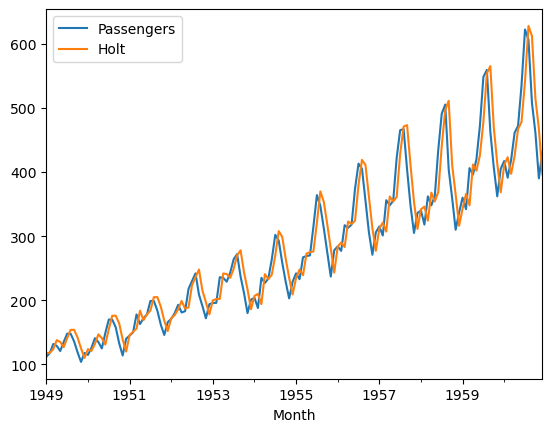

In [30]:
# Plotting the Holt column along with the original TS (i.e,. 'Passengers')
df[['Passengers', 'Holt']].plot();

As we can see, this is similar to the previous model where all it does is seem to track the previous value.

The next step is to use our train-test split again so we can do a real forecast.

In [31]:
# Creating a new Holt's object and passing in the train set
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
# Call fit() with no arguments
res_h = holt.fit()
# Assigning the fitted values to our df for the rows corresponding to the train set
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [32]:
# Call forecast for N_test time steps and then assign the result to our df for the rows corresponding to the test set.
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

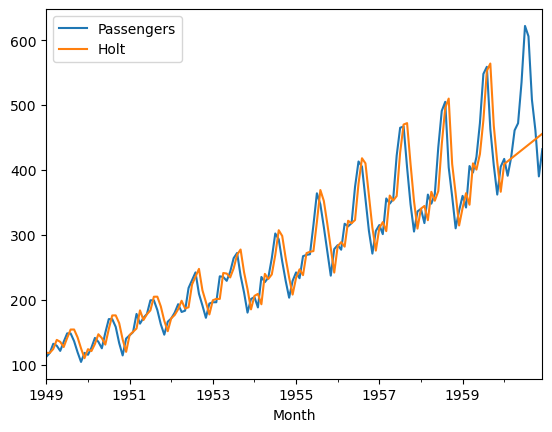

In [33]:
# Plotting "Holt" column along with the original time sereies
df[['Passengers', 'Holt']].plot();

We get a straight line trending upwards, which is exactly what the Holt Linear Trend Model should do in this scenario.

------------------------

## Holt-Winters

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### All Additive Holt-Winters model

In [35]:
# Creating an instance of our model. 
# Calling the train-test split rather that fitting a model to the entire dataset.
# Trying "Additive" model only first and then call the .fit() function.
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [36]:
# Assigning the fitted values to the Holt Winters column of our original df for the train rows.
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [37]:
# We call the forecast() for N_test steps and assign the results to our original df for the test rows.
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

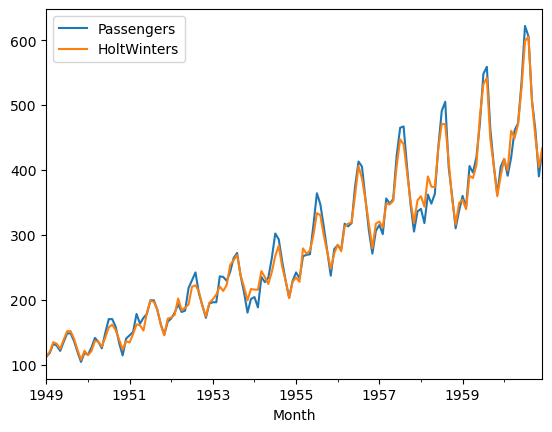

In [38]:
# Plotting the Holt Winters column along with the original dataset.
df[['Passengers', 'HoltWinters']].plot();

This is very encouraging. Unlike the Simple Exponential Smoothing (SES) model and Holt’s Linear Trend Model, this model provides a good fit for both the training and testing sets
```python
--------------------------------
```
Now that we know our model fits quite well, it would be a good idea to calculate some metrics. Although there are many metrics used in Time Series analysis, we’ll go with `Root Mean Squared Error (RMSE)` and `Mean Absolute Error (MAE)`.

In [39]:
# Calculating RMSE
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

# Checking the RMSE in both the train and test sets
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)),"\n")

# Calculating MAE
def mae(y, t):
  return np.mean(np.abs(y - t))

# Checking the MAE in both the train and test sets
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.852990975608384
Test RMSE: 15.543111574921017 

Train MAE: 8.892129241474121
Test MAE: 10.438273613134896


#### Additive trend and Multiplicative seasonality 

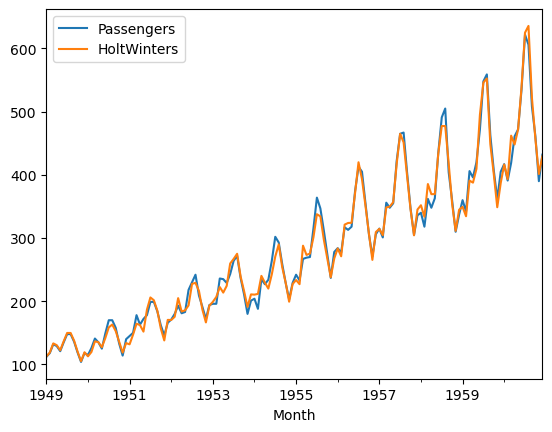

In [40]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot();

So from my perspective at least, this model appears to fit better than the purely additive model. Let's check the metrics.

In [41]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)),"\n")

print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 10.153934838980446
Test RMSE: 16.53521274372282 

Train MAE: 7.5520526448052845
Test MAE: 10.68334156323617


#### Multiplicative trend and Additive seasonality 

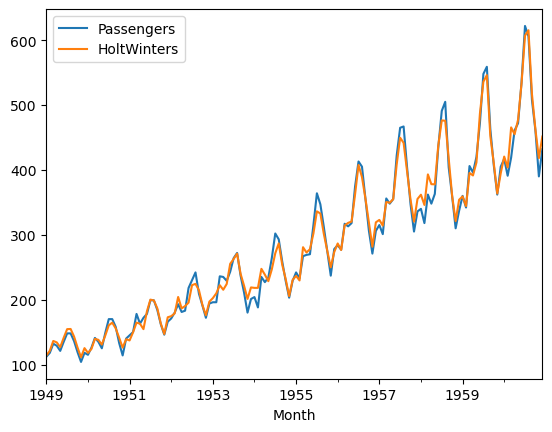

In [42]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot();

In [43]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)),"\n")

print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.649485848456795
Test RMSE: 18.213459802243413 

Train MAE: 8.906239128648702
Test MAE: 13.192586660593335


#### Multiplicative only model

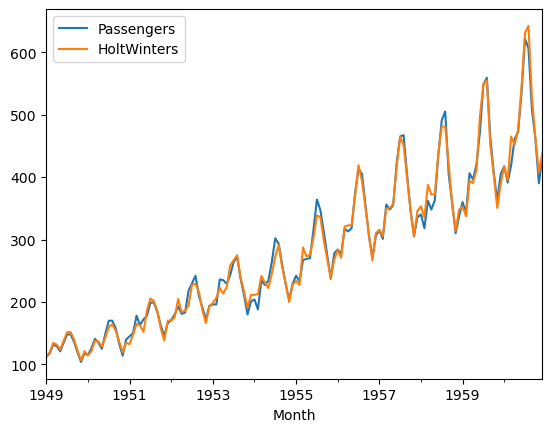

In [44]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot();

In [45]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)), "\n")

print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.887178133859093
Test RMSE: 19.102093666490106 

Train MAE: 7.408706879667877
Test MAE: 13.450514902523045


Except for the Additive-only model, the other three models appear to overfit the training data, resulting in poorer performance on the test data, as confirmed by the RMSE and MAE metrics. Therefore, in this case, it would be better to choose the Additive-only model, as it provides superior predictions on the test data when comparing both RMSE and MAE.